# Proteasome proteins' expression in tumor vs. normal samples

This notebook uses permutation testing to investigate the abundance levels of proteins making up the proteasome in tumor vs. normal samples.

Import needed packages.

In [1]:
import cptac
import pcanalyzer as pc
import seaborn as sns
import matplotlib.pyplot as plt

Load the datasets.

In [2]:
# cptac.download("brca")
# cptac.download("ccrcc")
# cptac.download("colon")
# cptac.download("endometrial")

# cptac.download("gbm")
# cptac.download("hnscc")

# cptac.download("lscc")
# cptac.download("luad")

# cptac.download("ovarian")

In [3]:
datasets = []

#datasets.append(cptac.Brca()) # Brca has no normal samples
datasets.append(cptac.Ccrcc())
datasets.append(cptac.Colon())
datasets.append(cptac.Endometrial())

datasets.append(cptac.Gbm())
datasets.append(cptac.Hnscc())

datasets.append(cptac.Lscc())
# datasets.append(cptac.Luad()) # Uses too much RAM

datasets.append(cptac.Ovarian())

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (/fslhome/lindgcm4/.local/lib/python3.7/site-packages/ipykernel_launcher.py, line 8)


Get a list of proteins within the proteasome. We have data from both CORUM and HGNC on which proteins are contained in particular protein complexes. However, the HGNC data is more comprehensive--it contains proteins that aren't  included in the CORUM data. Additionally, the CORUM data breaks it up into more specific  subgroups than HGNC, so the HGNC data is easier to query when we just want all proteins associated with a particular structure.

In [4]:
hgnc_lists = pc.get_hgnc_protein_lists()
proteasome_proteins = sorted(set(hgnc_lists["Proteasome"]))

Test which proteins have a significant difference between the mean expression in tumor vs. normal samples.

In [5]:
# Run the tests
num_permutations = 10000
results, num_tests = pc.perm_test_omics_pancancer(
    datasets=datasets,
    id_list=proteasome_proteins,
    data_type="proteomics",
    num_permutations=num_permutations)

# Set our alpha and calculate the minimum P value we can report
alpha = 0.05 / num_tests
min_P = 1 / num_permutations

# Sort out results between those increased and decreased, of those with P below alpha, and print the results
print(f"Num tests: {num_tests}\nAlpha: {alpha}\nNum permutations: {num_permutations}\nMin P: {min_P}\n")

increased = {}
decreased = {}
above_alpha = {}

for dataset_name, ds_results in results.items():
    
    increased[dataset_name] = ds_results.loc[(ds_results["diff"] >= 0) & (ds_results["P_val"] <= alpha), :]
    decreased[dataset_name] = ds_results.loc[(ds_results["diff"] < 0) & (ds_results["P_val"] <= alpha), :]
    above_alpha[dataset_name] = ds_results.loc[ds_results["P_val"] > alpha, :]
            
    print("\n\n---------------------------------------------------------------------")
    print(f"{dataset_name}\nIncreased:")
    print(increased[dataset_name])
    
    print("\nDecreased:")
    print(decreased[dataset_name])
    
    print(f"\nP > alpha:")
    print(above_alpha[dataset_name])    

Num tests: 286
Alpha: 0.00017482517482517483
Num permutations: 10000
Min P: 0.0001



---------------------------------------------------------------------
ccrcc
Increased:
                             diff   P_val
(PSMA1, NP_002777.1)     0.274008  0.0000
(PSMA2, NP_002778.1)     0.277024  0.0000
(PSMA3, NP_002779.1)     0.167801  0.0000
(PSMA4, NP_001096137.1)  0.110089  0.0000
(PSMA5, NP_002781.2)     0.297547  0.0000
(PSMA6, NP_002782.1)     0.252228  0.0000
(PSMA7, NP_002783.1)     0.205970  0.0000
(PSMB1, NP_002784.1)     0.266850  0.0000
(PSMB10, NP_002792.1)    1.405130  0.0000
(PSMB2, NP_002785.1)     0.213942  0.0000
(PSMB3, NP_002786.2)     0.094346  0.0001
(PSMB4, NP_002787.2)     0.243256  0.0000
(PSMB8, NP_683720.2)     0.936154  0.0000
(PSMB9, NP_002791.1)     1.235056  0.0000
(PSMC1, NP_002793.2)     0.149478  0.0000
(PSMC2, NP_002794.1)     0.080719  0.0000
(PSMC3, NP_002795.2)     0.119226  0.0000
(PSMC4, NP_006494.1)     0.094526  0.0000
(PSMC5, NP_002796.4)     0.12

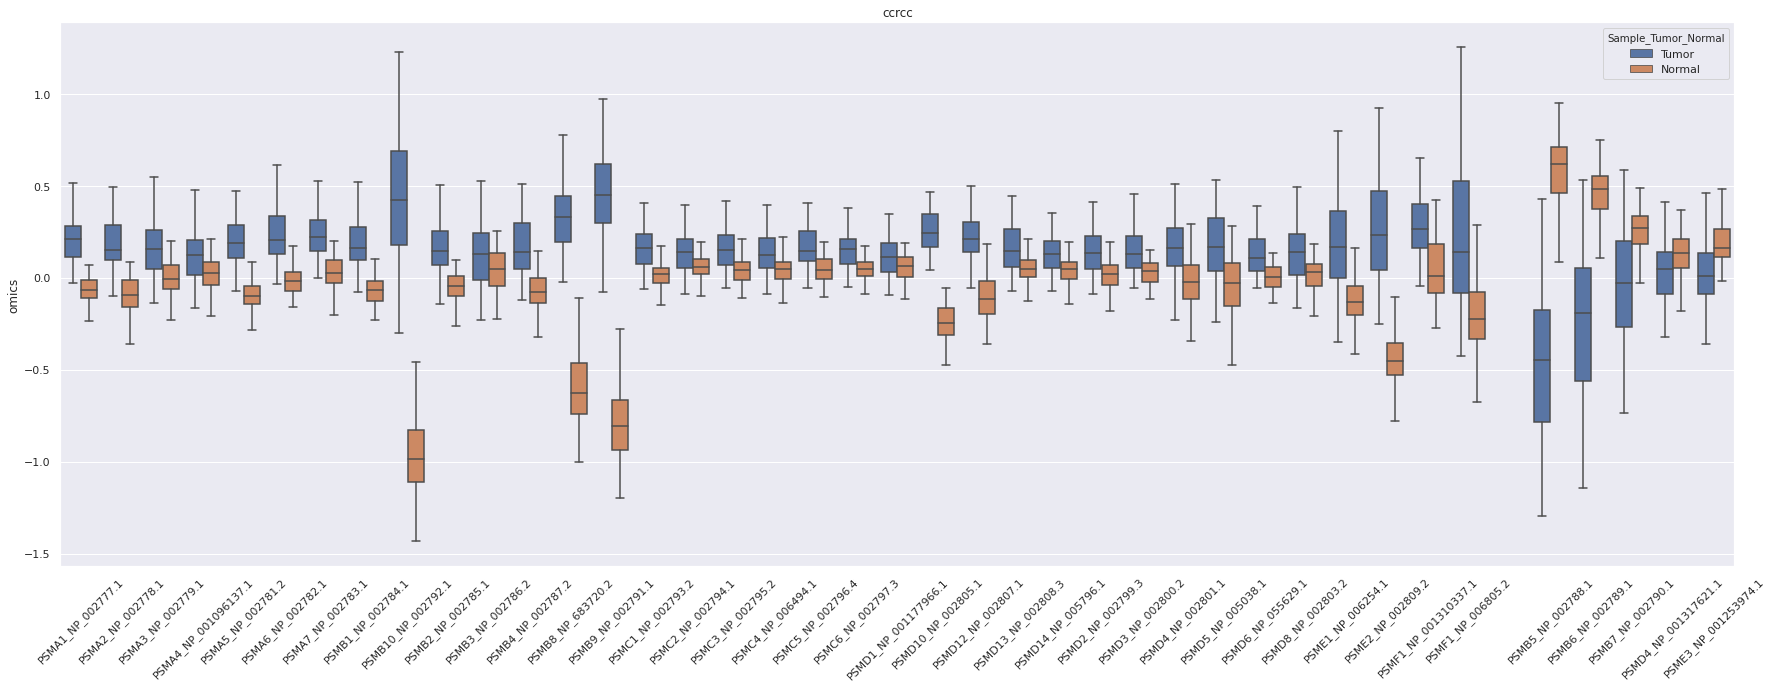

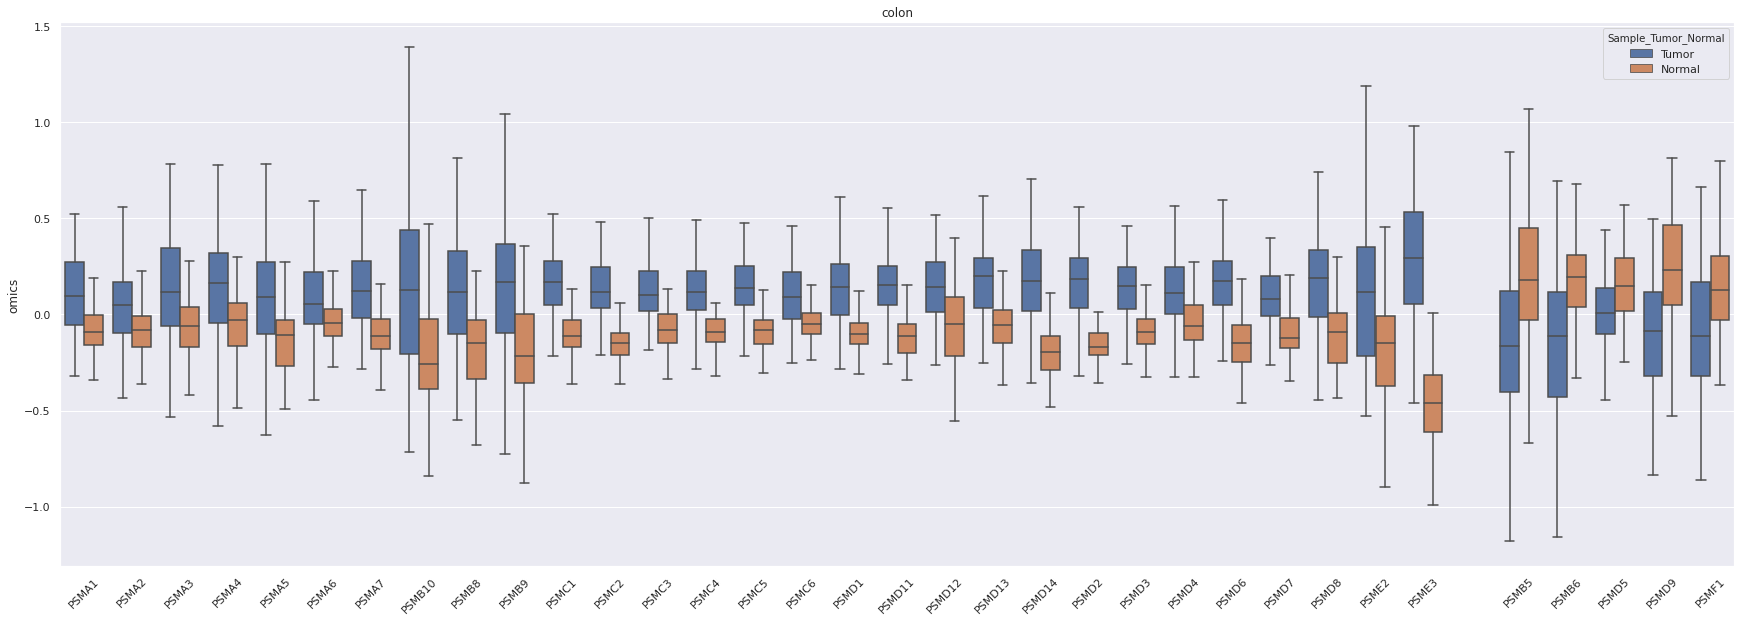

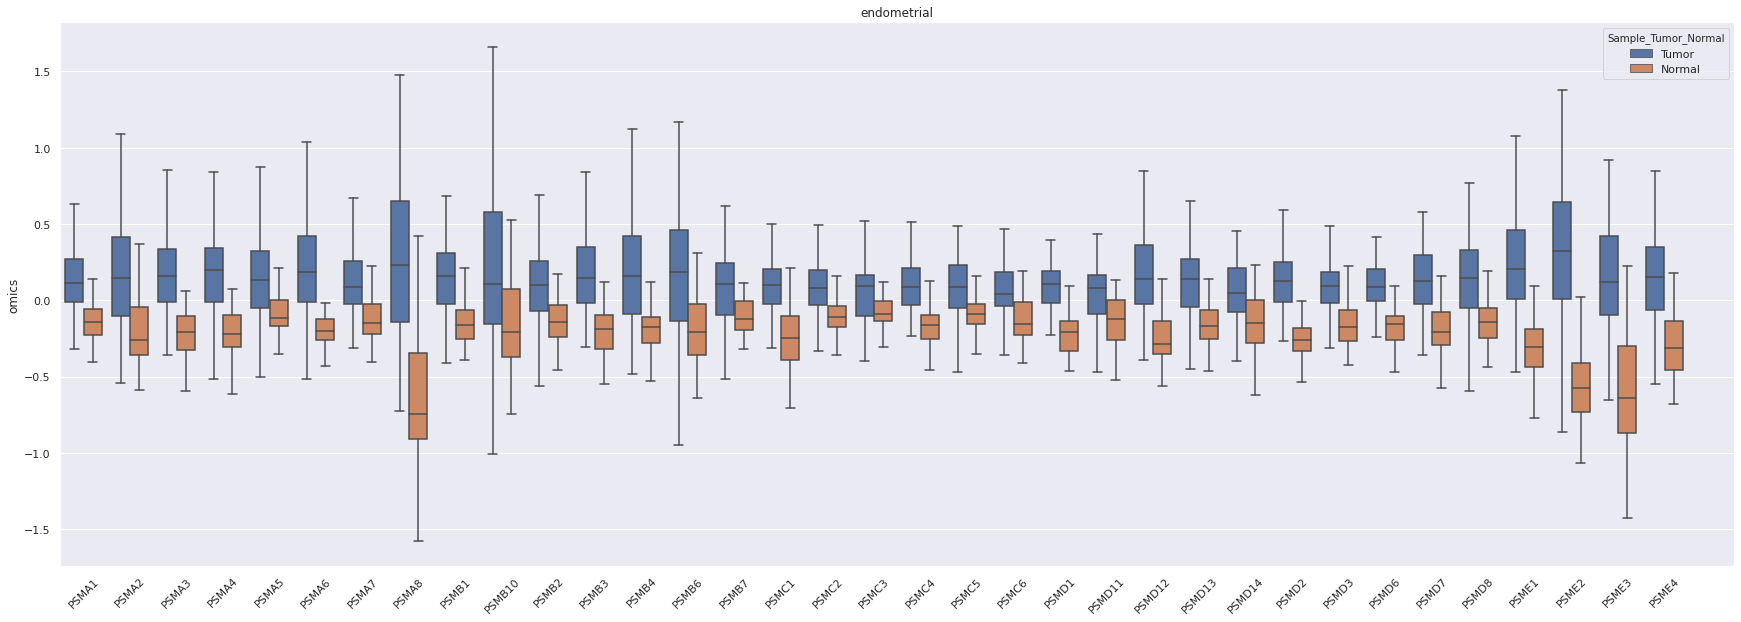

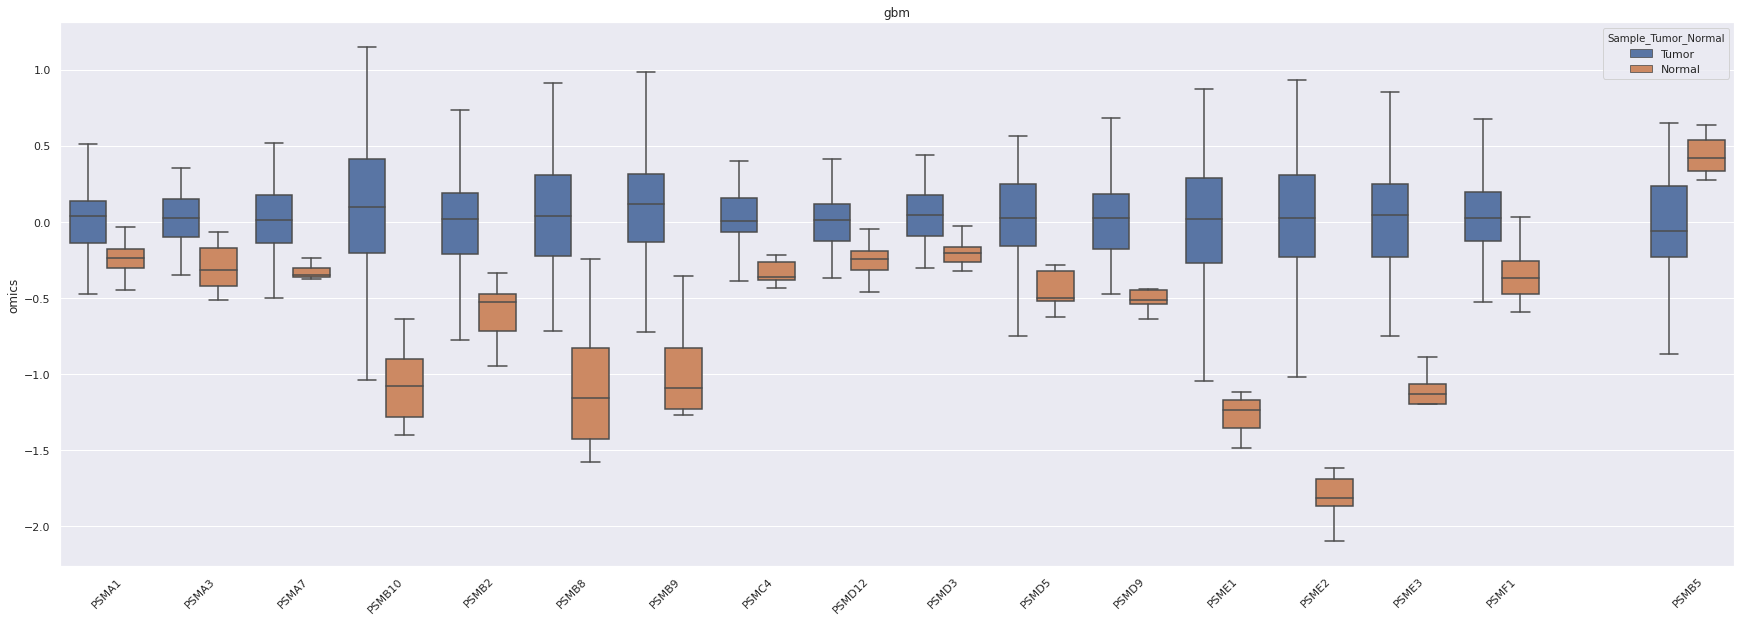

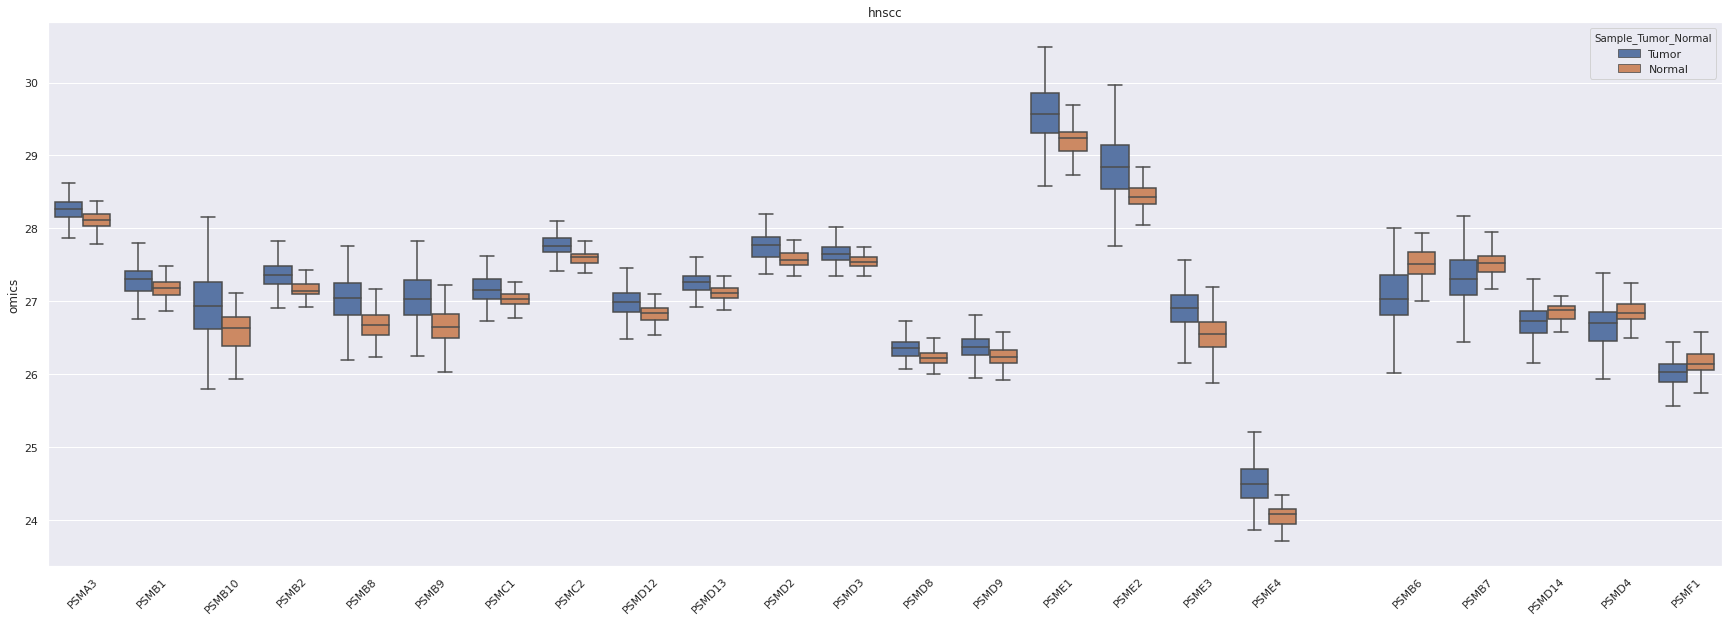

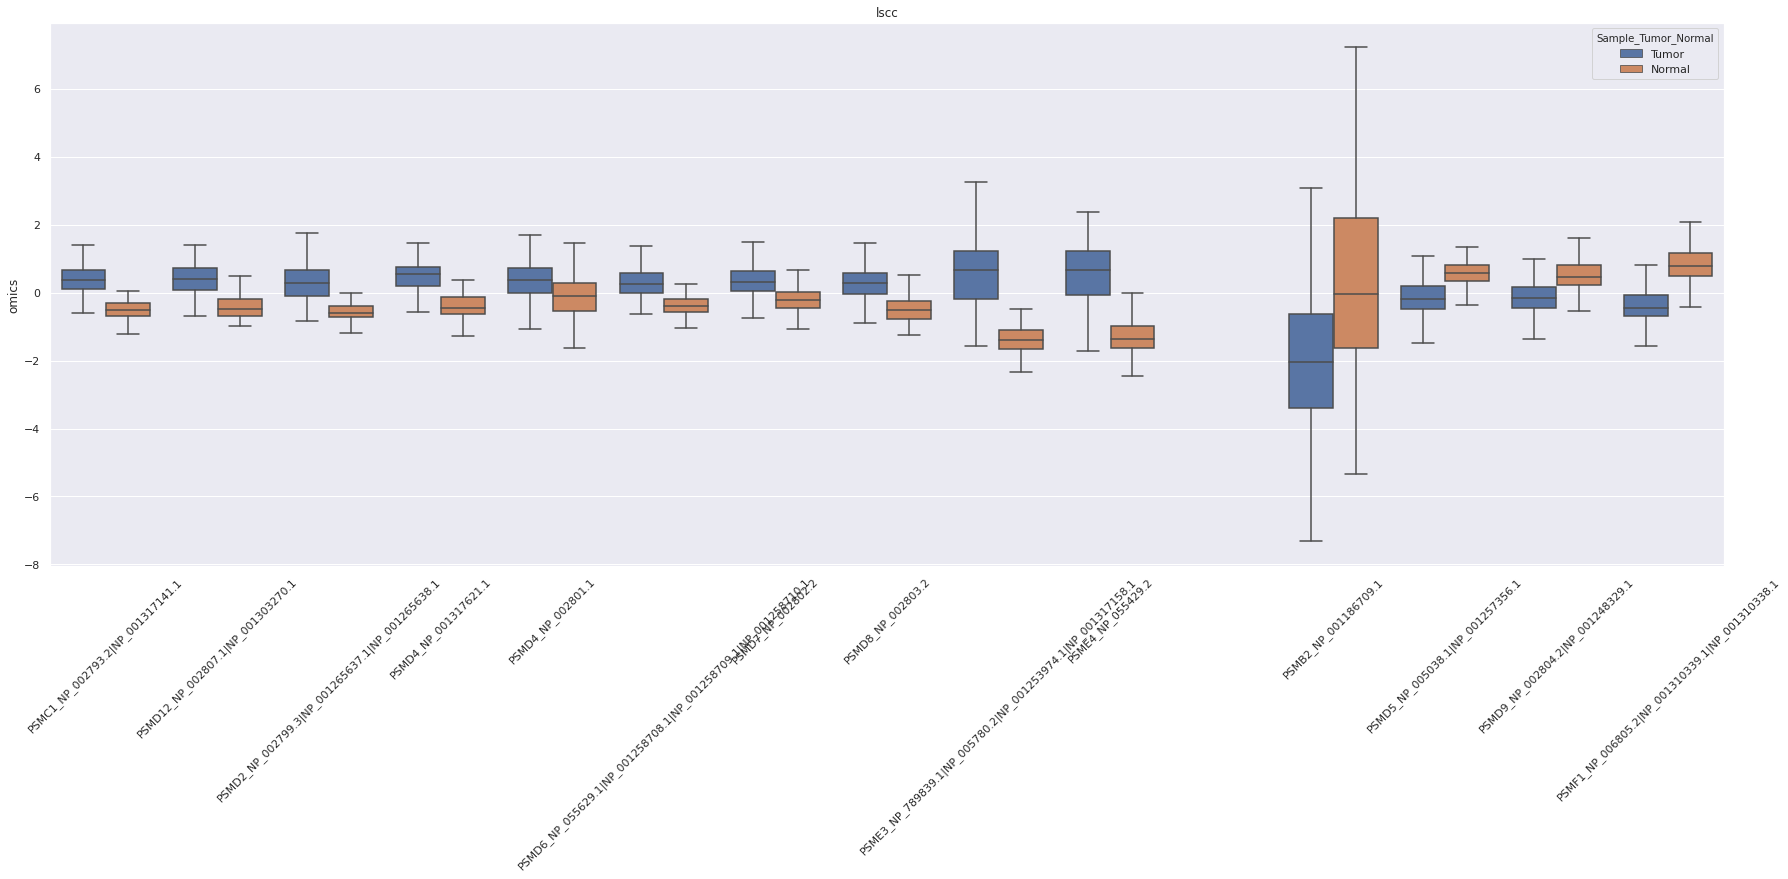

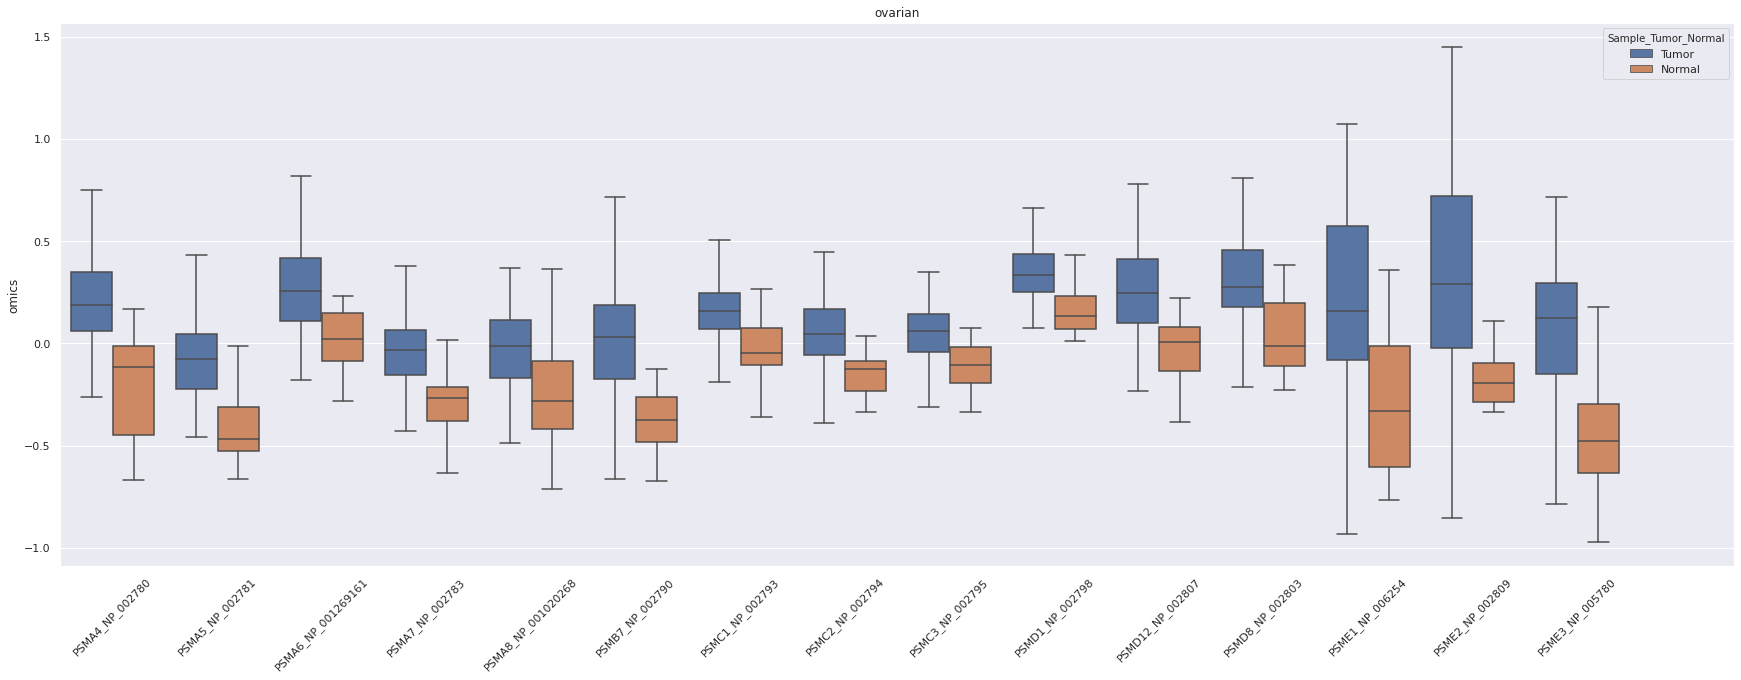

In [6]:
for dataset in datasets:
    ds_name = dataset.get_cancer_type()
    pc.boxplot_omics_tumor_normal(
        dataset=dataset,
        data_type="proteomics",
        separated_ids=[increased[ds_name].index.to_list(), decreased[ds_name].index.to_list()],
        dims=(30, 10)
    )

In [7]:
# Next: Write a function to do boxplots, based off Amanda's, and then plot the results for proteins 
# with a significant difference. Then, test it on the supercomputer for all proteins will small
# numbers of permutations; then run with large numbers of permutations.